# Dimensionality Reduction using an Autoencoder
Welcome to this project. We will introduce the theory behind an autoencoder (AE), its uses, and its advantages over PCA, a common dimensionality reduction technique.

## Some Prerequisites
- Basic-to-intermediate level understanding of Python
- Basic theory of neural networks is beneficial, but not required

## Project Outline
[**Task 1**](#task1): Package Importing and Introduction to Project

[**Task 2**](#task2): Dataset Creation and Preprocessing

[**Task 3**](#task3): Create a Baseline Model with PCA

[**Task 4**](#task4): Autoencoder Introduction and Training

[**Task 5**](#task5): Reducing Dimensionality with AE

<a id='task1'></a>
## Task 1: Importing and Introduction

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, silhouette_score

In [3]:
colors = ['#1FC17B', '#78FECF', '#555B6E', '#CC998D', '#429EA6',
        '#153B50', '#8367C7', '#EE6352', '#C287E8', '#F0A6CA', 
        '#521945', '#361F27', '#828489', '#9AD2CB', '#EBD494', 
        '#53599A', '#80DED9', '#EF2D56', '#446DF6', '#AF929D']

<a id='task2'></a>
## Task 2: Dataset Creation and Preprocessing

In [4]:
X, y = make_blobs(n_samples    = 20000,
                  n_features   = 50,
                  centers      = 20,
                  cluster_std  = 0.2,
                  center_box   = (-1.0, 1.0),
                  random_state = 17)

In [5]:
display(X.shape)
display(y.shape)

(20000, 50)

(20000,)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.1,
                                                    random_state = 17)

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

<a id='task3'></a>
## Task 3: Baseline Model

In [8]:
pca = PCA(n_components = 2)

pca.fit(X_train)
X_test_pca = pca.transform(X_test)

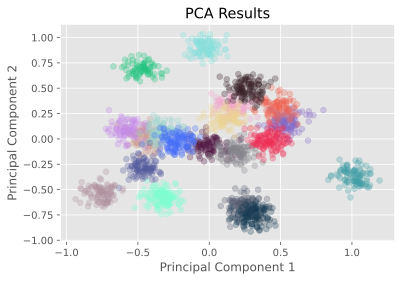

In [9]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    X_data = X_test_pca[y_test==label]
    
    plt.scatter(X_data[:,0], X_data[:,1], alpha=0.3, c=colors[index])

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title('PCA Results')
plt.show()

<a id='task4'></a>
## Task 4: Autoencoder Theory and Training
![title](https://github.com/kevinpulido89/ML/blob/master/Images/ae_viz.pdf?raw=1)

https://blog.keras.io/building-autoencoders-in-keras.html

In [10]:
autoencoder = MLPRegressor(hidden_layer_sizes=(50,100,75,50,2,50,75,100,50),
                           alpha=1e-15,
                           batch_size=batch_size,
                           max_iter=25000,
                           random_state=None)

autoencoder.fit(X_train, X_train)

NameError: ignored

<a id='task5'></a>
## Task 5: Reducing Dimensionality with Encoder

In [ ]:
W = autoencoder.coefs_
biases = autoencoder.intercepts_

In [ ]:
for w in W:
    print(w.shape)

In [ ]:
encoder_weights = W[0:5]
encoder_biases = biases[0:5]

In [ ]:
def encode(encoder_weights, encoder_biases, data):
    res_ae = data
    for index, (w,b) in enumerate(zip(encoder_weights, encoder_biases)):
        if index+1 == len(encoder_weights):
            res_ae = res_ae@w+b
        else:
            res_ae = np.maximum(0, res_ae@w+b)
            
    return res_ae

In [ ]:
res_AE = encode(encoder_weights, encoder_biases, X_test) # (2000, 2)

In [ ]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = res_AE[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [ ]:
silhouette_score(X_test, y_test)

In [ ]:
silhouette_score(X_test_pca, y_test)

In [ ]:
silhouette_score(res_AE, y_test)

## Let's build the simplest possible autoencoder

We'll start simple, with a single fully-connected neural layer as encoder and as decoder:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

- https://blog.keras.io/building-autoencoders-in-keras.html
- https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/
- https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

### Encoder

In [ ]:
# this is the size of our encoded representations
encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_size = 50

# this is our input placeholder 50,100,75,50,2
input_img = Input(shape=(input_size,))
# x = Dropout(0.20)(input_img)
# x = LeakyReLU(alpha=0.1)(x)
# x = BatchNormalization()(input_img)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(input_img)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

encoded = Dense(encoding_dim, activation='relu')(x)

# this model maps an input to its encoded representation 
encoder = Model(input_img, encoded, name='Encoder')
encoder.summary()

### Decoder

In [ ]:
# create a placeholder for an encoded (32-dimensional) 2,50,75,100,50
latent_space = Input(shape=(encoding_dim,), name='DecoderLayerInput')

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(latent_space)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(75, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(100, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

x = Dense(50, kernel_initializer='he_normal', activity_regularizer=regularizers.l1(10e-5))(x)
# x = Dropout(0.20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)

decoded_output = Dense(input_size, activation='sigmoid', name='DecoderLayerOut')(x)

# create the decoder model
decoder = Model(latent_space, decoded_output, name='Decoder')
decoder.summary()

### Autoencoder

In [ ]:
autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
autoencoder.summary()

In [ ]:
autoencoder.compile(optimizer='adam', # Or adadelta
                    loss='binary_crossentropy') #binary_crossentropy/mse

### Train AutoEncoder

Now let's train our autoencoder to reconstruct MNIST digits. First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
epochs = 50
batch_size=64

History = autoencoder.fit(X_train, X_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_test, X_test))

After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about 0.092

### Encode-Decode 
Encode and decode some digits

In [ ]:
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)

decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
N = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, History.history["loss"], label="train_loss")
plt.plot(N, History.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

We can try to visualize the reconstructed inputs and the encoded representations.

In [ ]:
unique_labels = np.unique(y_test)

for index, label in enumerate(unique_labels):
    latent_space = encoded_imgs[y_test==label]
    
    plt.scatter(latent_space[:,0], latent_space[:,1], alpha=0.3, c=colors[index])
    
plt.xlabel("Latent X")
plt.ylabel("Latent Y")
plt.title('AutoEncoder Results')
plt.show()

In [ ]:
silhouette_score(encoded_imgs, y_test)

## AutoEncoders for MNIST

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, fashion_mnist
import numpy as np
import pandas as pd
import seaborn as sns
import random

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
(mnist_train, _), (mnist_test, _) = mnist.load_data()

# We will normalize all values between 0 and 1
mnist_train = mnist_train.astype('float32') / 255.
mnist_test = mnist_test.astype('float32') / 255.

# we will flatten the 28x28 images into vectors of size 784.
mnist_train = mnist_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
mnist_test  = mnist_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(mnist_train.shape)
print(mnist_test.shape)

In [ ]:
epochs = 50
batch_size=64

History_mnist = autoencoder.fit(x = mnist_train,
                                y = mnist_train,
                                epochs = epochs,
                                batch_size = batch_size,
                                shuffle = True,
                                validation_data = (X_test, X_test))

In [ ]:
n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(mnist_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images    
    ax = plt.subplot(3, n, 2*20+i + 1 )
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Image Denoising using AutoEncoders

In [ ]:
(fm_X_train, fm_y_train), (fm_X_test, fm_y_test) = fashion_mnist.load_data()

In [ ]:
print('fm_X_train shape', fm_X_train.shape)
print('fm_X_test shape', fm_X_test.shape)
plt.imshow(fm_X_train[625], cmap='gray')
plt.show()

### Perform Data visualization

In [ ]:
i = random.randint(i,60000)
print(fm_y_train[i])
plt.imshow(fm_X_train[i], cmap='gray')
plt.show()

- 0 = T-shirt/top
- 1 = Trouser
- 2 = Pullover
- 3 = Dress
- 4 = Coat
- 5 = Sandal
- 6 = Shirt
- 7 = Sneaker
- 8 = Bag
- 9 = Ankle boot

In [ ]:
# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_training = len(fm_X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid*L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow(fm_X_train[index])
    axes[i].set_title(fm_y_train[index], fontsize = 8, color = 'w')
    axes[i].axis('off')
plt.show()

In [ ]:
# Normalize data
fm_X_train = fm_X_train/255.0
fm_X_test = fm_X_test/255.0

In [ ]:
# Add noise to images
noise_factor = 0.38

noise_train_dataset = list()
noise_test_dataset = list()

for img in fm_X_train:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_train_dataset.append(noisy_image)

for img in fm_X_test:
    noisy_image = img + noise_factor*np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    noise_test_dataset.append(noisy_image)

In [ ]:
noise_train_dataset = np.array(noise_dataset)
noise_test_dataset = np.array(noise_test_dataset)

In [ ]:
plt.imshow(fm_X_train[3], cmap='gray')
plt.show()

In [ ]:
plt.imshow(noise_dataset[3], cmap='gray')
plt.show()

### UNDERSTAND THE THEORY AND INTUITION BEHIND AUTOENCODERS

![image.png](attachment:image.png)

Introduction to autoencoders by Jeremy Jordan

https://www.jeremyjordan.me/autoencoders/

![image.png](attachment:image.png)

![image.png](attachment:image.png)

### Convolutional autoencoder

In [ ]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(filters =  8, kernel_size = (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name = 'LatentSpace')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 8, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters = 16, kernel_size = (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

In [ ]:
fm_X_train = np.reshape(fm_X_train, (len(fm_X_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_train_dataset = np.reshape(noise_train_dataset, (len(noise_train_dataset), 28, 28, 1))

fm_X_test = np.reshape(fm_X_test, (len(fm_X_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
noise_test_dataset = np.reshape(noise_test_dataset, (len(noise_test_dataset), 28, 28, 1))

In [ ]:
import datetime

In [ ]:
log_dir = "logsTF" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
epochs = 12
batch_size = 64

HistoryAE = autoencoder.fit(noise_train_dataset,
                            fm_X_train,
                            epochs = epochs,
                            batch_size = batch_size,
                            validation_data = (noise_test_dataset, fm_X_test),
                            callbacks=[tensorboard_callback]
                           )

In [ ]:
tensorboard --logdir=logsFT

In [ ]:
plt.plot(HistoryAE.history[0])
plt.show()

In [ ]:
Evaluation = autoencoder.evaluate(noise_test_dataset,
                                  fm_X_test,
                                  batch_size=batch_size,
                                  verbose=2)

print('Test Loss: {:.3f}'.format(Evaluation))

In [ ]:
predicted = autoencoder.predict(noise_test_dataset[:10])

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([noise_test_dataset[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>

# Introduction to Anomaly Detection in Time Series with Keras

## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 7
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


## Task 2: Load and Inspect the S&P 500 Index Data

In [2]:
df = pd.read_csv('/content/S&P_500_Index_1927_2020.csv', parse_dates=['Date'])
print(df.shape)
display(df)

(23227, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...,...
23222,2020-06-15,2993.760010,3079.760010,2965.659912,3066.590088,3066.590088,5740660000
23223,2020-06-16,3131.000000,3153.449951,3076.060059,3124.739990,3124.739990,5829240000
23224,2020-06-17,3136.129883,3141.159912,3108.030029,3113.489990,3113.489990,4549390000
23225,2020-06-18,3101.639893,3120.000000,3093.510010,3115.340088,3115.340088,4429030000


In [3]:
mask = (df['Date'] > '1980-01-01') & (df['Date'] <= '2020-06-19')
df = df.loc[mask]
df = df.filter(items=['Date', 'Close'], axis=1)
df.reset_index(drop=True, inplace=True)

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= df.Date, y= df.Close, mode='lines', name='Close'))
fig.update_layout(showlegend = True)
fig.show()

## Task 3: Data Preprocessing

In [5]:
train_size = int(len(df)* 0.8)
test_size =  len(df) - train_size

train = df.iloc[0:train_size]
test  = df.iloc[train_size:len(df)]

print(train.shape, test.shape)

(8164, 2) (2041, 2)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

In [7]:
train[['Close']].head()

,Close
0,-1.313280
1,-1.314437
2,-1.311652
3,-1.311030
4,-1.306445


## Task 4: Create Training and Test Splits

In [8]:
def create_sequences(X, y, time_steps=1):

  Xs, ys = [], []

  for i in range(len(X) - time_steps):
    Xs.append(X.iloc[i:(i+time_steps)].values) # Extrae los n_timesteps valores, 
    ys.append(y.iloc[i+time_steps]) # Extrae los n_timesteps+1 valores

  return np.array(Xs), np.array(ys)

In [9]:
time_steps = 30

X_train, y_train = create_sequences(train[['Close']], train.Close, time_steps) # Atencion al doble parentesis del Train[['Close']]
X_test, y_test = create_sequences(test[['Close']], test.Close, time_steps)


In [10]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8134, 30, 1) (8134,)
(2011, 30, 1) (2011,)


## Task 5: Build an LSTM Autoencoder

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [12]:
timesteps = X_train.shape[1] # 30
num_features = X_train.shape[2] # 1

In [13]:
model = Sequential(name='LSTM_AutoEncoder', layers=[
        
        LSTM(128, input_shape=(timesteps, num_features), recurrent_dropout=0.2),
        Dropout(0.2),
        RepeatVector(timesteps),
        LSTM(128, return_sequences=True, recurrent_dropout=0.2),
        Dropout(0.2),
        TimeDistributed(Dense(num_features))                 
])

model.compile(optimizer='Adam', loss='mae') #metrics=['Accuracy']

model.summary()

Model: "LSTM_AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
____________________________________________

## Task 6: Train the Autoencoder

In [15]:
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[eStop],
                    shuffle = False)

Epoch 1/100
229/229 [==============================] - 41s 180ms/step - loss: 0.1387 - val_loss: 0.2216
Epoch 2/100
229/229 [==============================] - 42s 183ms/step - loss: 0.1107 - val_loss: 0.1045
Epoch 3/100
229/229 [==============================] - 41s 179ms/step - loss: 0.0781 - val_loss: 0.0797
Epoch 4/100
229/229 [==============================] - 40s 175ms/step - loss: 0.0728 - val_loss: 0.0818
Epoch 5/100
229/229 [==============================] - 40s 174ms/step - loss: 0.0666 - val_loss: 0.1085
Epoch 6/100
229/229 [==============================] - 39s 172ms/step - loss: 0.0715 - val_loss: 0.0990


## Task 7: Plot Metrics and Evaluate the Model

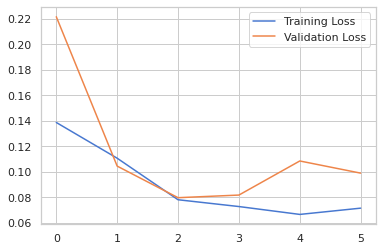

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [18]:
from sklearn import metrics

# Constants
C="Car"
F="Motor"
H="person"

# True values
y_true = [C,C,C,C,C,C, F,F,F,F,F,F,F,F,F,F, H,H,H,H,H,H,H,H,H]
# Predicted values
y_pred = [C,C,C,C,H,F, C,C,C,C,C,C,H,H,F,F, C,C,C,H,H,H,H,H,H]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

ValueError: ignored